# SCohenLab 2D BATCH Image Processing notebook (Simplified MCZ)

--------------
# PIPELINE OVERVIEW
## ❶ GOAL SETTING ✍

### GOAL:  Infer sub-cellular components in order to understand interactome 

To measure shape, position, size, and interaction of eight organelles/cellular components (Nuclei (NU), Lysosomes (LS),Mitochondria (MT), Golgi (GL), Peroxisomes (PO), Endoplasmic Reticulum (ER), Lipid Droplet (LD), and SOMA) during differentiation of iPSCs, in order to understand the Interactome / Spatiotemporal coordination.

### summary of _OBJECTIVES_ ✅
- robust inference of subcellular objects:
  -  #### 1️⃣. [infer NUCLEI ](./01_infer_nuclei.ipynb) 
  -  #### 2️⃣. [Infer SOMA](./02_infer_soma.ipynb) (🚨🚨🚨🚨 Steps 3-9 depend on establishing a good solution here.)
  -  #### 3️⃣. [Infer CYTOSOL](./03_infer_cytosol.ipynb)
  -  #### 4️⃣. [Infer LYSOSOMES](./04_infer_lysosome.ipynb)
  -  #### 5️⃣. [Infer MITOCHONDRIA](./05_infer_mitochondria.ipynb)
  -  #### 6️⃣. [Infer GOLGI complex](./06_golgi.ipynb)
  -  #### 7️⃣. [Infer PEROXISOMES](./07_peroxisome.ipynb)
  -  #### 8️⃣. [Infer ENDOPLASMIC RETICULUM ](./08_endoplasmic_reticulum.ipynb)
  -  #### 9️⃣. [Infer LB](./09_lipid_bodies.ipynb) 






## ❷ DATA CREATION
> METHODS:📚📚
> 
> iPSC lines prepared and visualized on Zeiss Microscopes. 32 channel multispectral images collected.  Linear Unmixing in  ZEN Blue software with target emission spectra yields 8 channel image outputs.  Channels correspond to: Nuclei (NU), Lysosomes (LS),Mitochondria (MT), Golgi (GL), Peroxisomes (PO), Endoplasmic Reticulum (ER), Lipid Droplet (LD), and a “residual” signal.

> Meta-DATA 🏺 (artifacts)
>   - Microcope settings
>  - OME scheme
> - Experimenter observations
> - Sample, bio-replicate, image numbers, condition values, etc
>  - Dates
>  - File structure, naming conventions
>  - etc.





## ❸. IMAGE PROCESSING ⚙️🩻🔬
### INFERENCE OF SUB-CELLULAR OBJECTS
The imported images have already been pre-processed to transform the 32 channel spectral measuremnts into "linearly unmixed" images which estimate independently labeled sub-cellular components.  Thes 7 channels (plus a residual "non-linear" signal) will be used to infer the shapes and extents of these sub-cellular components.   
We will perform computational image analysis on the pictures (in 2D an 3D) to _segment_ the components of interest for measurement.  In other prcoedures we can used these labels as "ground truth" labels to train machine learning models to automatically perform the inference of these objects.
Pseudo-independent processing of the imported multi-channel image to acheive each of the 9 objecives stated above.  i.e. infering: NUCLEI, SOMA, CYTOSOL, LYSOSOME, MITOCHONDRIA, GOLGI COMPLEX, PEROZISOMES, ENDOPLASMIC RETICULUM, and LIPID BODIES

### General flow for infering objects via segmentation
- Pre-processing 🌒
- Core-processing (thresholding) 🌕
- Post-processing  🌘

### QC 🚧 WIP 🚧 




## ❹. QUANTIFICATION 📏📐🧮

SUBCELLULAR COMPONENT METRICS
-  extent 
-  size
-  shape
-  position



### NOTE: PIPELINE TOOL AND DESIGN CHOICES?
We want to leverage the Allen Cell & Structure Setmenter.  It has been wrapped as a [napari-plugin](https://www.napari-hub.org/plugins/napari-allencell-segmenter) but fore the workflow we are proving out here we will want to call the `aicssegmentation` [package](https://github.com/AllenCell/aics-segmentation) directly.

#### ​The Allen Cell & Structure Segmenter 
​The Allen Cell & Structure Segmenter is a Python-based open source toolkit developed at the Allen Institute for Cell Science for 3D segmentation of intracellular structures in fluorescence microscope images. This toolkit brings together classic image segmentation and iterative deep learning workflows first to generate initial high-quality 3D intracellular structure segmentations and then to easily curate these results to generate the ground truths for building robust and accurate deep learning models. The toolkit takes advantage of the high replicate 3D live cell image data collected at the Allen Institute for Cell Science of over 30 endogenous fluorescently tagged human induced pluripotent stem cell (hiPSC) lines. Each cell line represents a different intracellular structure with one or more distinct localization patterns within undifferentiated hiPS cells and hiPSC-derived cardiomyocytes.

More details about Segmenter can be found at https://allencell.org/segmenter
In order to leverage the A
# IMPORTS

import  all nescessary packages

we are using `napari` for visualization, and `scipy` `ndimage` and `skimage` for analyzing the image files.  The underlying data format are `numpy` `ndarrays` and tools from  Allen Institute for Cell Science.


In [6]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np
import scipy

# TODO:  prune the imports.. this is the big set for almost all organelles
# # function for core algorithm
from scipy import ndimage as ndi
from scipy.ndimage import median_filter
import aicssegmentation
from aicssegmentation.core.seg_dot import dot_3d_wrapper, dot_slice_by_slice, dot_2d_slice_by_slice_wrapper, dot_3d
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         image_smoothing_gaussian_slice_by_slice, edge_preserving_smoothing_3d )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import filament_2d_wrapper, vesselnessSliceBySlice
from aicssegmentation.core.output_utils import   save_segmentation,  generate_segmentation_contour
                                                 
from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation, remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.utils.file_io import (read_czi_image, 
                                                                    list_image_files, 
                                                                    export_ome_tiff, 
                                                                    etree_to_dict, 
                                                                    save_parameters, 
                                                                    load_parameters, 
                                                                    export_ndarray)

from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )

from infer_subc_2d.utils.img import *
from infer_subc_2d.organelles import *

%load_ext autoreload
%autoreload 2

test_img_n = TEST_IMG_N

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



------------------------
# LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [7]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [8]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [9]:
# # make sure we have removed Z
# if len(scale)>2:
#     scale = scale[1:]

## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

In [10]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 
img_2D = img_data[:,[optimal_Z],:,:].copy()


Now get the single "optimal" slice of all our organelle channels....

## get the inferred soma, nuclei and cytosol objects

(takes < 1 sec)

Builde the segmentations in order




In [12]:
###################
# SOMA, NUCLEI, CYTOSOL
###################
soma_mask =  infer_soma(img_2D) 

nuclei_object =  infer_nuclei(img_2D, soma_mask) 
cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 


###################
# LYSOSOME
###################
lysosome_object =  infer_lysosomes(img_2D, cytosol_mask) 

###################
# MITOCONDRIA
###################
mito_object =  infer_mitochondria(img_2D, cytosol_mask) 

###################
#  GOLGI
###################
golgi_object =  infer_golgi(img_2D, cytosol_mask) 



###################
#  PEROXISOME
###################
peroxi_object =  infer_peroxisome(img_2D, cytosol_mask) 


###################
#  ER
###################
er_object =  infer_endoplasmic_reticulum(img_2D, cytosol_mask) 



NameError: name 'LIPID_CH' is not defined

In [13]:

###################
#  LIPID BODY
###################
lipid_object =  infer_lipid_body(img_2D, cytosol_mask) 


## View

In [14]:
viewer = napari.Viewer()

In [15]:
viewer.add_image(
    nuclei_object,
    scale=scale,
    colormap='blue', 
    blending='additive'
)
viewer.add_image(
    lysosome_object,
    scale=scale,
    colormap='cyan', 
    blending='additive'
)

viewer.add_image(
    mito_object,
    scale=scale,
    colormap='green', 
    blending='additive'
)

viewer.add_image(
    golgi_object,
    scale=scale,
    colormap='yellow', 
    blending='additive'
)


viewer.add_image(
    peroxi_object,
    scale=scale,
    colormap='bop orange', 
    blending='additive'
)


viewer.add_image(
    er_object,
    scale=scale,
    blending='additive')

viewer.add_image(
    lipid_object,
    scale=scale,
    blending='additive')



<Image layer 'lipid_object' at 0x18a3299d0>

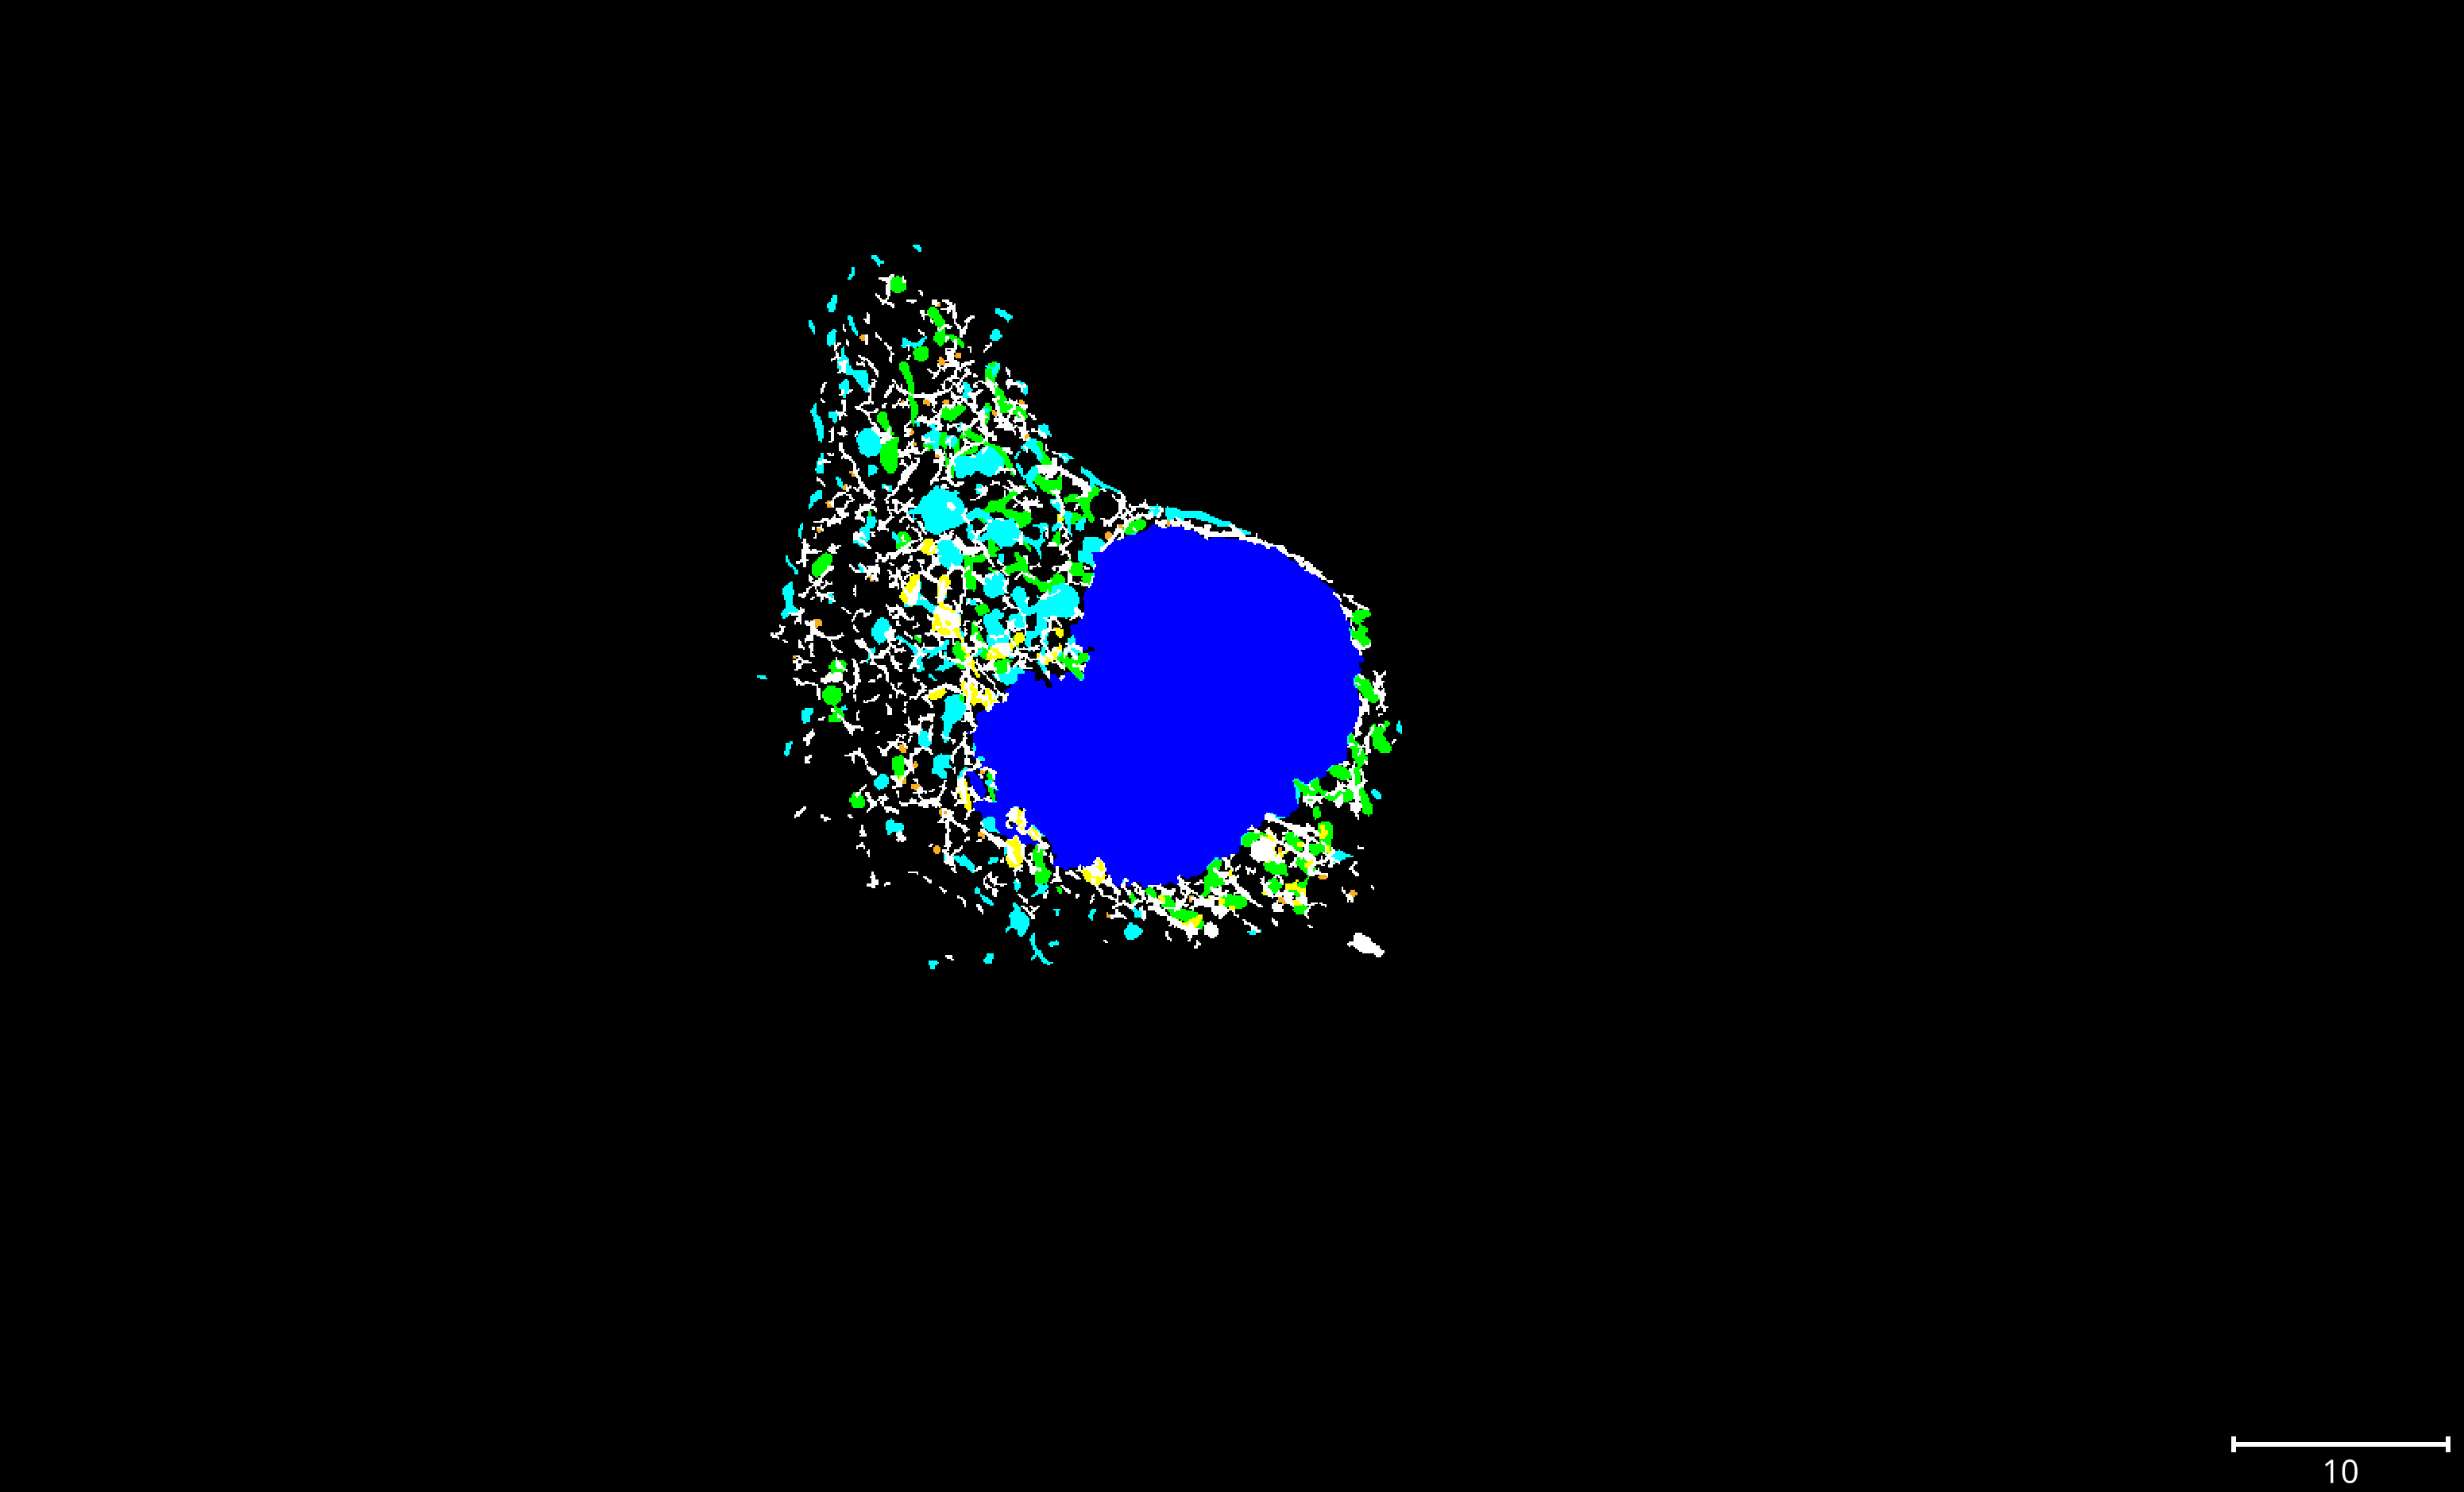

In [16]:
viewer.scale_bar.visible = True
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


There may be a bug where the input images to the "infer_*" functions are modified in place and we might need to access them.  _MASKING_ seems to be the problem.  Also need to be clear about _when_ to apply the mask.

In [63]:

###########
# infer organelles
##########
def _infer_organelles(img_data):

    ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
    nuc_ch = NUC_CH
    optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 
    # Stage 1:  nuclei, soma, cytosol
    img_2D = img_data[:,[optimal_Z],:,:].copy()
    soma_mask =  infer_soma(img_2D) 

    nuclei_object =  infer_nuclei(img_2D, soma_mask) 

    cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 


    # cyto masked objects.
    lysosome_object =  infer_lysosomes(img_2D, cytosol_mask) 
    mito_object =  infer_mitochondria(img_2D, cytosol_mask) 
    golgi_object =  infer_golgi(img_2D, cytosol_mask) 
    peroxi_object =  infer_peroxisome(img_2D, cytosol_mask) 
    er_object =  infer_endoplasmic_reticulum(img_2D, cytosol_mask) 
    lipid_object =  infer_lipid_body(img_2D, cytosol_mask) 

    img_layers = [nuclei_object,
                            lysosome_object,
                            mito_object,
                            golgi_object,
                            peroxi_object,
                            er_object,
                            soma_mask,
                            cytosol_mask]
                            
    layer_names = ["nuclei","lysosome","golgi","peroxisome","er","lipid_body","soma_mask", "cytosol_mask"]

    img_out = np.stack(img_layers, axis = 0)
    return (img_out, layer_names, optimal_Z)



In [64]:


inferred_organelles, layer_names, optimal_Z = _infer_organelles(img_data)


In [25]:
viewer = napari.Viewer()


NameError: name 'length' is not defined

In [54]:
cmaps = ['blue','cyan','green','yellow','bop orange','magenta','gray','gray','gray']

for i,organelle in enumerate(inferred_organelles):
    viewer.add_image(
        organelle,
        scale=scale,
        blending='additive',
        name = layer_names[i],
        colormap=cmaps[i]
    )


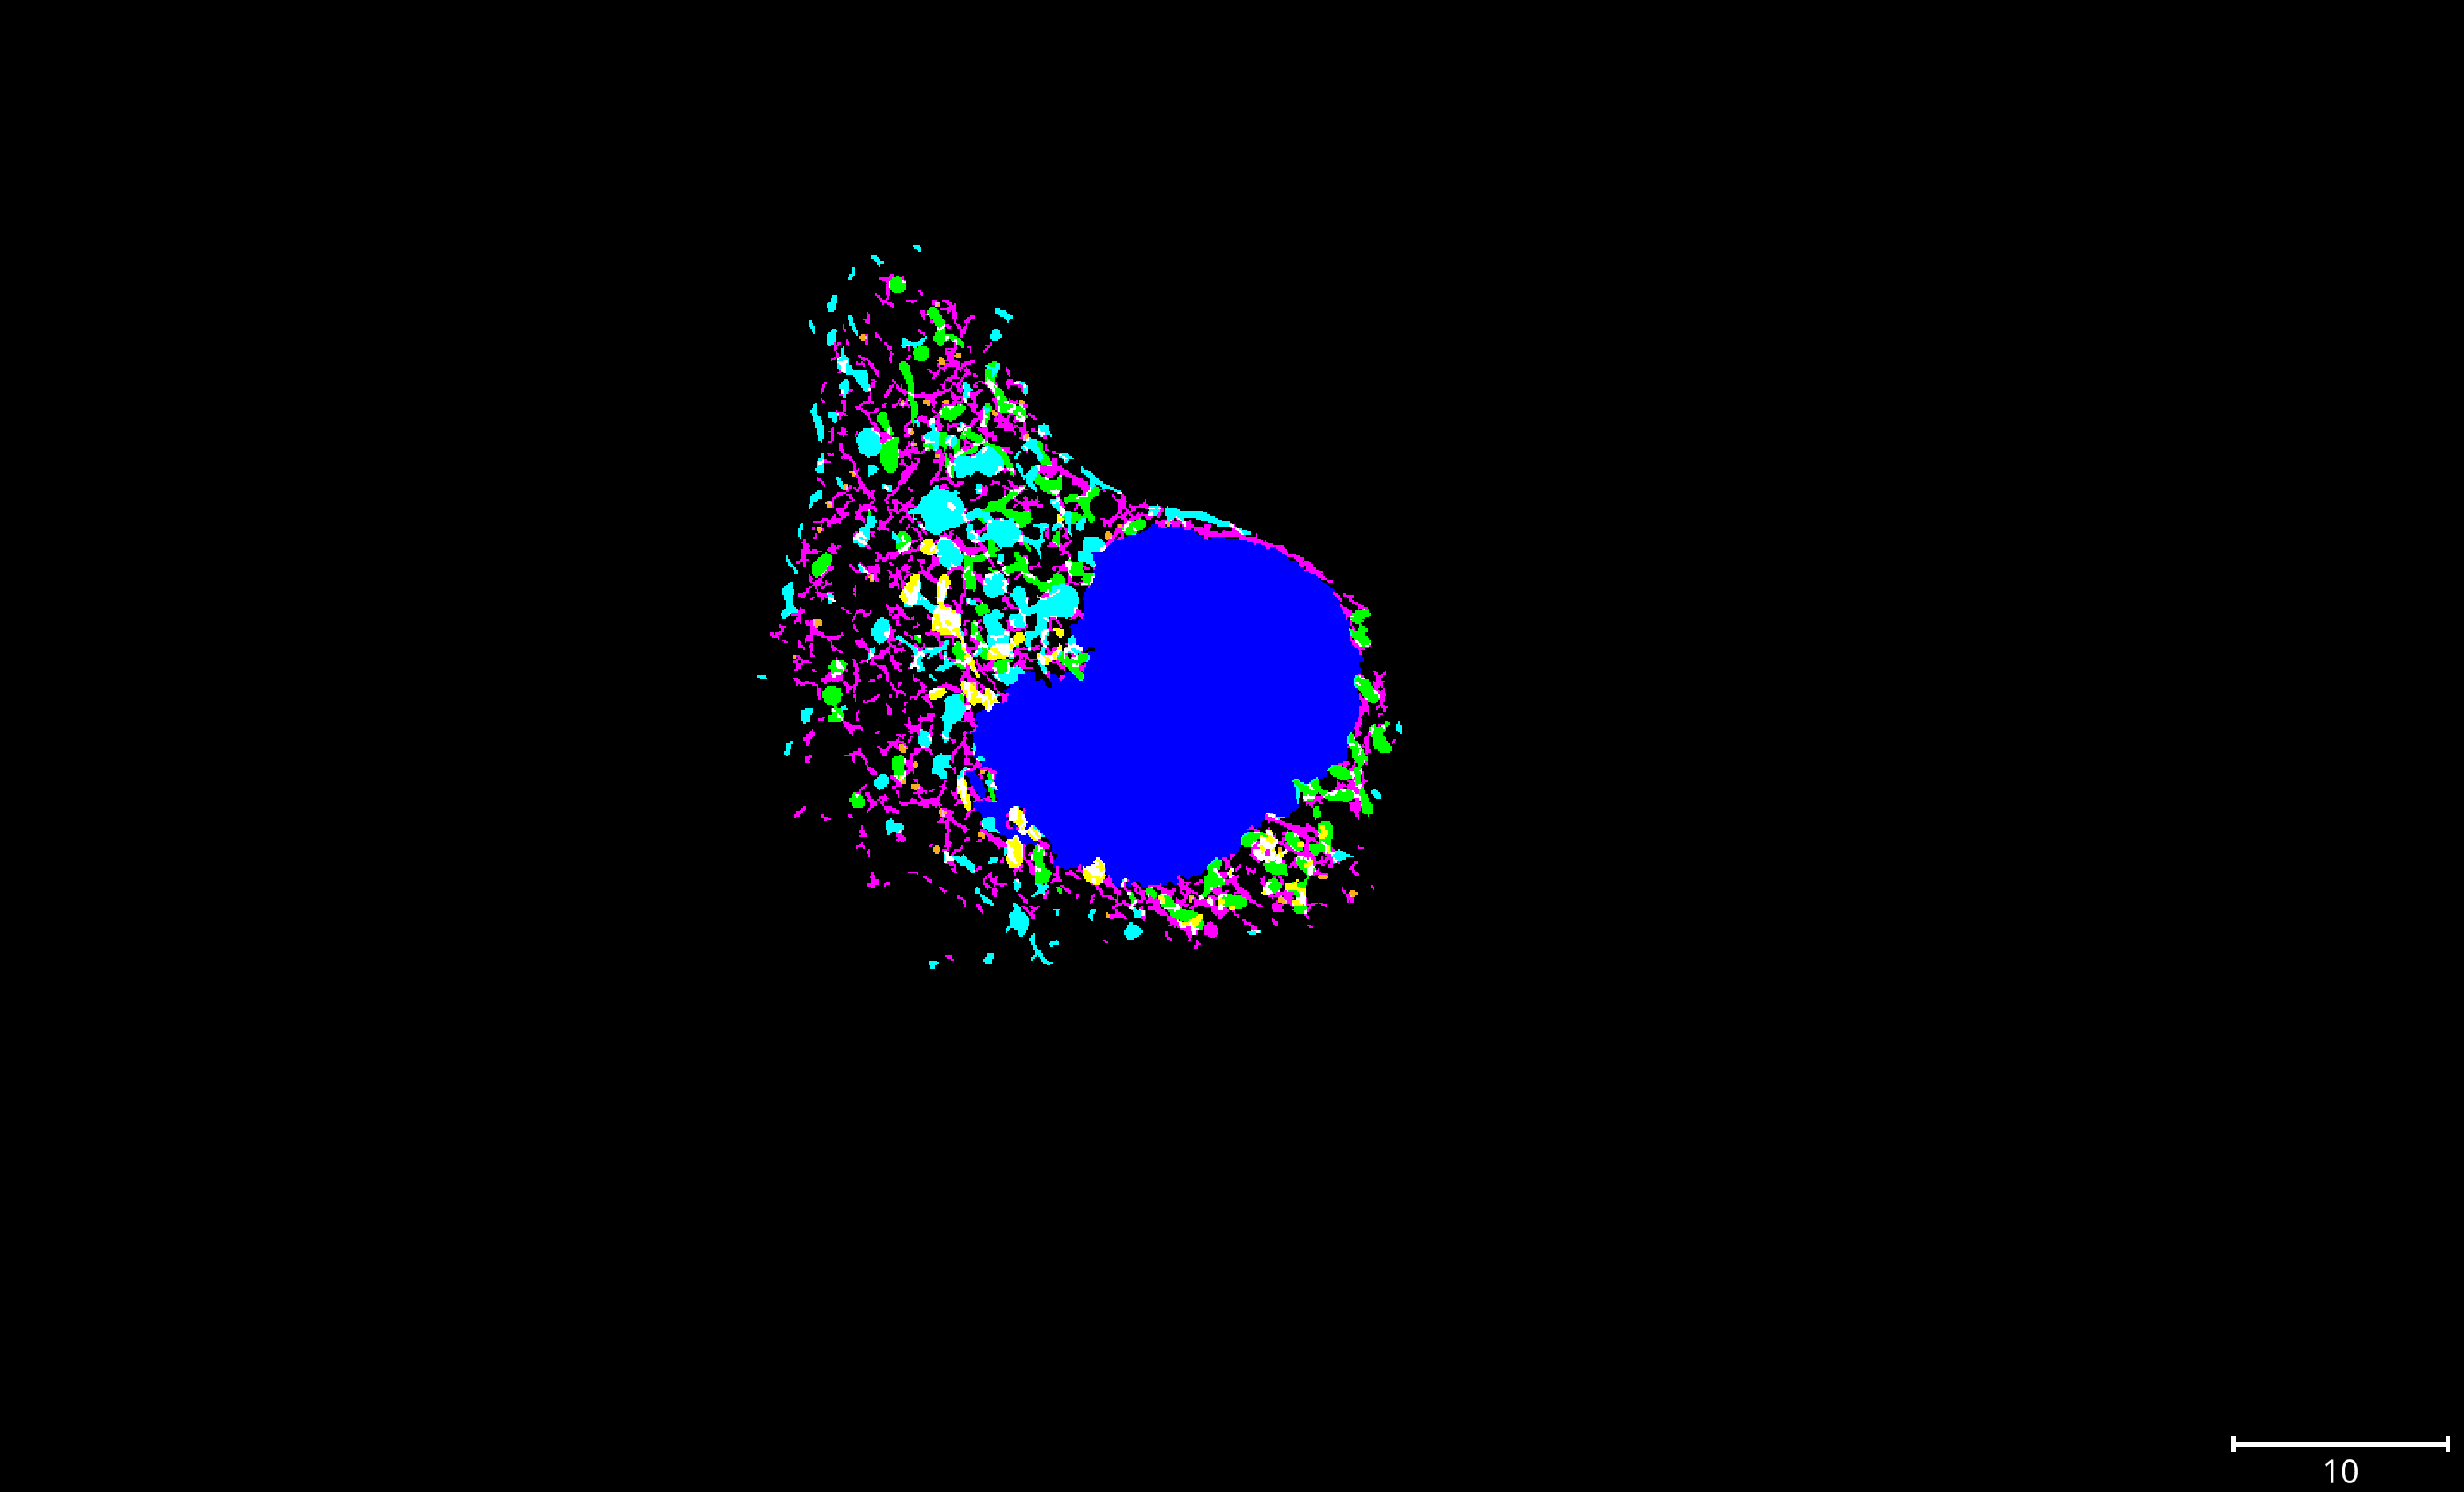

In [55]:
viewer.scale_bar.visible = True

nbscreenshot(viewer, canvas_only=True)

In [57]:
meta_dict

{'name': ['0 :: None :: Nuclei_Jan22',
  '0 :: None :: Lyso+405_Jan22',
  '0 :: None :: Mito+405_Jan22',
  '0 :: None :: Golgi+405_Jan22',
  '0 :: None :: Peroxy+405_Jan22',
  '0 :: None :: ER+405_Jan22',
  '0 :: None :: BODIPY+405low_Jan22',
  '0 :: None :: Residuals'],
 'channel_axis': 0,
 'scale': (0.5804527163320905, 0.07987165184837318, 0.07987165184837318),
 'metadata': {'aicsimage': <AICSImage [Reader: CziReader, Image-is-in-Memory: False]>,
  'raw_image_metadata': <Element 'ImageDocument' at 0x14a9c1360>},
 'file_name': '/Users/ahenrie/Projects/Imaging/data/raw/ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.czi'}

In [61]:

##################
# export
##################

def _export_infer_organelles(img_out, layer_names, meta_dict, data_root_path):
       # get some top-level info about the RAW data
    # channel_names = meta_dict['name']
    # img = meta_dict['metadata']['aicsimage']
    # scale = meta_dict['scale']
    # channel_axis = meta_dict['channel_axis']
    img_name = meta_dict['file_name']
    # add params to metadata
    meta_dict['layer_names'] = layer_names
    out_path = data_root_path / "inferred_objects" 
    img_name_out = 'binarized_' + img_name.split("/")[-1].split(".")[0]

    out_file_n = export_ome_tiff(img_out, meta_dict, img_name_out, str(out_path)+"/", layer_names)
    print(f"saved file: {out_file_n}")
    return out_file_n

out_file_n = _export_infer_organelles(inferred_organelles, layer_names, meta_dict, data_root_path)



saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff


The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


In [60]:
out_file_n

'/Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff'

----------------------

run a batch of ALL the images

First get all the images

In [ ]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"



now build a function to loop over them all and export




In [68]:

def batch_process_all_czi(data_root_path):

    # linearly unmixed ".czi" files are here
    data_path = data_root_path / "raw"
    im_type = ".czi"
    # get the list of all files
    img_file_list = list_image_files(data_path,im_type)
    files_generated = []
    for czi_file in img_file_list:
        out_fn = process_czi_image(czi_file)
        files_generated.append(out_fn)

    print(f"generated {len(files_generated)} ")
    return files_generated

def process_czi_image(czi_file_name):
    """wrapper for processing"""

    img_data,meta_dict = read_czi_image(czi_file_name)
    # # get some top-level info about the RAW data
    # channel_names = meta_dict['name']
    # img = meta_dict['metadata']['aicsimage']
    # scale = meta_dict['scale']
    # channel_axis = meta_dict['channel_axis']

    inferred_organelles, layer_names,optimal_Z = _infer_organelles(img_data)
    meta_dict['z_slice'] = optimal_Z
    out_file_n = _export_infer_organelles(inferred_organelles, layer_names, meta_dict, data_root_path)

    ## TODO:  collect stats... 

    return out_file_n


In [69]:
output_tiffs = batch_process_all_czi(data_root_path)


saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N08_Unmixed.ome.tiff
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR1_N16_Unmixed.ome.tiff
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR2_N02_Unmixed.ome.tiff
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N14_Unmixed.ome.tiff
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N01_Unmixed.ome.tiff
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N11_Unmixed.ome.tiff
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR1_N21_Unmixed.ome.tiff
saved fi

35 files processed in 6 minutes 47 seconds!!

In [70]:

tiff_img_data,tiff_meta_dict = read_czi_image(output_tiffs[-1])


The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


In [80]:
tiff_img_data.shape

img = tiff_meta_dict['metadata']['aicsimage']
img.dims

<Dimensions [T: 1, C: 8, Z: 1, Y: 768, X: 768]>

In [ ]:
from aicsimageio.writers import OmeTiffWriter
data_in = img_out
channel_names = [layer_names]
image_names = [img_name]
print(image_names)
# chan_names = meta_in['metadata']['aicsimage'].channel_names
dimension_order = ["CZYX"]

num_images = len(  [data_in.shape])
if data_in.dtype == "bool":
    data_in = data_in.astype(np.uint8)
    data_in[data_in > 0] = 255

physical_pixel_sizes = [meta_dict["metadata"]["aicsimage"].physical_pixel_sizes]
out_ome = OmeTiffWriter.build_ome(
        [data_in.shape],
        [data_in.dtype],
        channel_names=channel_names,  # type: ignore
        image_name=image_names,
        physical_pixel_sizes=physical_pixel_sizes,
        dimension_order=dimension_order,
    )